Erstellt von: 4757202 und 2100594

# Eroberung des Borg Kubus - Infos

Ziel: Zentrum des Kubus erreichen

64000 Drohnen an Bord

Spielfeld: 31x31x31

Benachbarte Koordinaten nicht immer voneinander erreichbar. Durchgänge unterschiedlich schwer

Flur entlang: 1 Feld, 1 Minute (also wenn x oder y Koordinate +/-)

Flur kann von Drohne bewacht sein. Drohnen können nicht ohne Kampf passiert werden. Kosten: 3 Minuten und eine Energieeinheit der Waffe

Wenn keine Ladung -> Drohne unpassierbar.

Nach Kampf braucht man 5 Minuten Regenerationszeit vor nächstem Kampf, man kann jedoch alle anderen Aktionen durchführen.

Leiter hoch: 2 Minuten (wenn z +) / runter: 0,5 Minuten (wenn z -)

Tür: 2 Minuten

Mit Tritanium Blaster kann ein Loch in eine Wand gesprengt werden. Kostet 3 Minuten (*Annahme: Es können mehrere Wände hintereinander gesprengt werden*)

Man kann innehalten, kostet 1 Minute.

Zerstörung Vinculum: 

- manuell (ohne Blaster): 5 Minuten
- mit Blaster: 1 Minute

Start der Suche: (15,6,10)

Anzahl Blaster: 11 / Ladezustand der Waffe: 13

# Implementierung

Auskommentierte Zeilen wie beispielsweise "prints" dienten zum besseren Verständnis bei der Erstellung und wurden im nachhinein auskommentiert, um die Abgabe übersichtlicher zu machen.

In [8]:
# Diese Zeile einkommentieren, falls die unten genannten Bibliotheken noch installiert werden müssen.
#%pip install pandas, numpy, matplotlib, itertools

In [9]:
# Import wichtiger Bibliotheken
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [10]:
# CSV-Datei einlesen
kubus = pd.read_csv("S2_borg_cube.csv", sep=";")

# Leerstellen der CSV-Datei mit 0 füllen 
kubus = kubus.fillna(0)

# Umbenennung der zweiten Koordinatenspaltennamen (ohne Punkte um späteren Problemen vorzubeugen)
kubus = kubus.rename(columns={"x.1": "x1", "y.1": "y1", "z.1": "z1"})

# Aufsplitten der Daten aus einem großen Dataframe in viele kleine Arrays, 
# durch die über den gemeinsamen Index auf die jeweiligen Daten zugegriffen werden kann
prev_pos = kubus[['x', 'y', 'z']].to_numpy()
next_pos = kubus[['x1', 'y1', 'z1']].to_numpy()
hasDoor = kubus['door'].to_numpy()
isOpen = kubus['open'].to_numpy()
hasSentinel = kubus['sentinel'].to_numpy()
hasLadder = kubus['ladder'].to_numpy()

# Anzeigen des Dataframes
kubus

,x,y,z,x1,y1,z1,door,open,sentinel,ladder
0,-15,-6,11,-14,-6,11,0.0,1.0,0.0,0.0
1,-15,-4,-4,-15,-3,-4,0.0,1.0,0.0,0.0
2,-14,-8,-7,-14,-8,-6,0.0,0.0,0.0,1.0
3,-14,-4,1,-13,-4,1,0.0,1.0,0.0,0.0
4,-14,-1,-8,-15,-1,-8,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2084,14,4,0,14,3,0,1.0,0.0,0.0,0.0
2085,14,6,10,15,6,10,0.0,1.0,0.0,0.0
2086,14,7,-1,15,7,-1,0.0,1.0,1.0,0.0
2087,14,13,0,15,13,0,0.0,1.0,0.0,0.0


In [11]:
# Klasse einer Node erstellen
class Node:

    # Klasse initialisieren
    def __init__(self, position:(), parent:()):
        self.position = position
        self.parent = parent
        self.g = 0 # G-Kosten
        self.h = 0 # H-Kosten
        self.f = 0 # Totale Kosten
        self.lf = -5 # Zeitpunkt des letzten Kampfes / -5, sodass erster Kampf auch in Zug 0 stattfinden kann
        self.wc = 0 # Weapon Charges
        self.tb = 0 # Tritanium Blaster Charges
        self.step = "" # Zur späteren Nachvollziehbarkeit der Bewegung

    # Nodes vergleichen
    def __eq__(self, other):
        return self.position == other.position

    # Nodes sortieren
    def __lt__(self, other):
         return self.f < other.f

    # Nodes ausgeben
    def __repr__(self):
        return '({0},{1})'.format(self.position, self.f)

# A* Suche
def astar_search(start, end, weapon_charges, tritanium_charges):
    
    # Liste für offene und geschlossene Nodes erstellen
    open = []
    closed = []
    node_count = 0

    # Start- und Zielnode erstellen
    # Die Startnode erhält die vorgegebene Anzahl an Waffen- und Tritaniumladungen
    start_node = Node(start, None)
    start_node.wc = weapon_charges
    start_node.tb = tritanium_charges
    goal_node = Node(end, None)

    # Startnode zur offenen Liste hinzufügen
    open.append(start_node)
    
    # So lange suchen, bis die offene Liste leer ist
    while len(open) > 0:

        # Offene Liste Sortieren, sodass die Node mit den niedrigsten F-Kosten an erster Stelle ist
        open.sort()
        #print("Sorted open list: ", open)

        # Node mit den niedrigsten Kosten zur aktuellen Node machen
        current_node = open.pop(0)

        # print("Current G:", current_node.g)
        # print("Current H:", current_node.h)
        # print("Current F:", current_node.f)
        # print("Current LF:", current_node.lf)
        # print("Current WC:", current_node.wc)
        # print("Current TB:", current_node.tb)
        # print("-----------------")

        # Aktuelle Node zur geschlossenen Liste hinzufügen
        closed.append(current_node)
        
        # Check, ob das Ziel erreicht wurde
        if current_node == goal_node:

            # Erstelle eine Liste für den Pfad und für die gemachten Schritte (zur besseren Verständnis)
            path = []
            final_steps = []

            # Finale Werte und Ressourcen werden von der current_node übernommen (befindet sich ja am Ziel)
            final_g = current_node.g                
            final_wc = current_node.wc
            final_tb = current_node.tb
            
            # Rückverfolgung aller genutzten Nodes
            while current_node != start_node:
                path.append(current_node.position)
                final_steps.append(current_node.step)
                current_node = current_node.parent
            path.append(start) 

            #print("Steps taken: ", final_steps)

            # Return reversed path
            print("Untersuchte Nodes: ", node_count)
            print("Final Cost: ", final_g, "Minutes")
            print("Final Weapon charges:", final_wc)
            print("Final Tritanium-Blaster charges:", final_tb)
            print("Weglänge:", len(path))

            # Gebe den Pfad (und mehr) in umgekehrter Reihenfolge zurück
            return path[::-1], closed, final_steps[::-1]

        # Position der aktuellen Node in ihre Koordinaten aufteilen
        (x, y, z) = current_node.position

        #print("Current position: ", current_node.position)

        # Alle möglichen anliegenden Wände ausgehend von der aktuellen Position
        # -1 als index, um sie später von realen Pfaden aus der csv-Datei zu unterscheiden
        # Sechster Fall (x, y, z+1) nicht beachtet, da tritanium blaster nicht nach oben möglich
        possible_walls = [[(x-1, y, z), -1], [(x+1, y, z), -1], [(x, y-1, z), -1], [(x, y+1, z), -1], [(x, y, z-1), -1]] 

        # Liste aller vorgegebenen Pfade initialisieren
        paths = []

        # Schleife, um alle anliegenden Pfade aus der csv-Datei zu erkennen und der paths-liste anzuhängen
        for i in range(len(prev_pos)):
            if prev_pos[i][0] == x and prev_pos[i][1] == y and prev_pos[i][2] == z or next_pos[i][0] == x and next_pos[i][1] == y and next_pos[i][2] == z:
                if prev_pos[i][0] == x and prev_pos[i][1] == y and prev_pos[i][2] == z:
                    # Es wird die Position und der Index (zur späteren Berechnung der Kosten) angehängt
                    paths.append([(next_pos[i][0], next_pos[i][1], next_pos[i][2]), i])
                else:
                    # Es wird die Position und der Index (zur späteren Berechnung der Kosten) angehängt
                    paths.append([(prev_pos[i][0], prev_pos[i][1], prev_pos[i][2]), i])

        # Liste aller Positionen der vorgegebenen Pfade erstellen
        path_positions = []
        for k in range(len(paths)):
            path_positions.append(paths[k][0])

        # Liste aller umliegenden Wände (für den Blaster) initialisieren
        walls = []

        # Schleife, um jede umliegende Wand (welche kein vorgegebener Pfad ist) der walls-Liste anzuhängen
        for next_possible_wall in possible_walls:
            if next_possible_wall[0] not in path_positions:
                walls.append(next_possible_wall)

        #print("Possible walls", possible_walls)
        #print("Paths: ", paths)
        #print("Walls: ", walls)

        # Zusammenfügen von Pfaden und Wänden
        all_paths = paths + walls

        #print("All paths: ", all_paths)

        # Durch alle der (maximal 6) möglichen Nachbarpfade loopen
        for next_neighbor in all_paths:

            # Nachbarnode erstellen
            neighbor = Node(next_neighbor[0], current_node)

            # Check ob die Nachbarnode bereits in der geschlossenen Liste ist
            # Wenn ja, fahre mit der nächsten Node fort
            if neighbor in closed:
                continue

            # Node count erhöhen (um zu sehen, wie viele Nodes insgesamt überprüft wurden)
            node_count += 1
            
            #print("Neighbor position: ", neighbor.position)

            # Index (zur späteren Kostenberechnung benötigt)
            index = next_neighbor[1]

            # G-Kosten und weitere Ressourcen berechnen 
            neighbor.g, neighbor.lf, neighbor.wc, neighbor.tb, neighbor.step = make_step(neighbor, index)

            # Heuristik generieren 
            # Gewählt wurde die minimale Distanz zum Ziel entlang der Koordinatenachsten
            neighbor.h = abs(neighbor.position[0] - goal_node.position[0]) + abs(neighbor.position[1] - goal_node.position[1]) + abs(neighbor.position[2] - goal_node.position[2])
            
            # F-Kosten berechnen
            neighbor.f = neighbor.g + neighbor.h
            
            # Check ob Nachbarnode bereits in der offenen Liste ist und wenn ja, ob sie niedrigere F-Kosten hat
            if add_to_open(open, neighbor):
                # Füge die Node der offenen Liste hinzu, wenn sie noch nicht darin existiert
                # ODER wenn sie bereits existiert, aber jetzt niedrigere F-Kosten besitzt
                open.append(neighbor)

    # Return None wenn kein Pfad gefunden wurde
    return None

# Check ob eine Nachbarnode zur offenen Liste hinzugefügt werden soll
def add_to_open(open, neighbor):
    for node in open:
        if neighbor == node and neighbor.f >= node.f:
            return False
    return True

# Funktion zur Berechnung der G-Kosten und weiterer Ressourcen
def make_step(neighbor, index):

    # Aus den neuen G-Kosten (new_g) für diese Node und den vorherigen Kosten (parent_g) wird später G berechnet 
    new_g = 0
    parent_g = neighbor.parent.g

    # Ressourcen der Parent-Node werden übernommen
    lf = neighbor.parent.lf
    wc = neighbor.parent.wc
    tb = neighbor.parent.tb

    # Info zur späteren Übersicht
    step_taken = ""

    #print("Index: ", index)

    # Wenn der Index -1 ist, handelt es sich bei der Nachbarnode um eine Wand
    # Existieren noch Ladungen für den Tritanium-Blaster, so kann sich in diese Wand geschossen werden
    if index == -1 and tb > 0 :
        new_g += 3
        tb -= 1
        step_taken = "blast wall (3 Minuten)"
        #print("Blasted through a wall! (+3 minutes, -1 tritanium blaster charges)")

    # Handelt es sich bei der Nachbarnode um eine Wand und es sind keine Ladungen für den Tritanium-Blaster
    # mehr vorhanden, so kann dieser Weg nicht genommen werden
    elif index == -1 and tb == 0:
        new_g += 1000 # Die Kosten um 1000 zu erhöhen ist keine optimale Lösung, aber es funktioniert in den allermeisten Fällen
        #print("No tritanium blaster charges left! Path is blocked")

    # Wenn eine Tür im Plan steht, erhöhe Kosten um 2
    elif hasDoor[index] == 1:
        #print("Went through door (+2 minutes)")
        step_taken = "door (2 Minuten)"
        new_g += 2

    # Überprüfe ob eine Leiter im Plan steht
    elif hasLadder[index] == 1:

        # Führt die Leiter nach unten, erhöhe Kosten um 0.5
        if neighbor.position[2] < neighbor.parent.position[2]:
            new_g += 0.5
            #print("Ladder down (+0.5 minutes)")
            step_taken = "ladder down (0,5 Minuten)"

        # Führt die Leiter nach oben, erhöhe Kosten um 2
        elif neighbor.position[2] > neighbor.parent.position[2]:
            #print("Ladder up (+2 minutes)")
            step_taken = "ladder up (2 Minuten)"
            new_g += 2

    # Überprüfe auf offenen Durchgang
    elif isOpen[index] == 1:

        # Wenn keine Drohne im Durchgang steht, erhöhe Kosten um 1
        if hasSentinel[index] == 0:
            new_g += 1
            #print("Open hallway (+1 minute)")
            step_taken = "open (1 Minute)"

        # Überprüfe, ob der Durchgang von eine Drohe bewacht ist und ob die Waffe noch Ladungen besitzt
        elif hasSentinel[index] == 1 and wc > 0:
            #print("Last fight g ", lf)
            #print("Parent g ", parent_g)

            # Wenn der Letzte Kampf noch keine 5 Minuten her ist, halte inne
            # (Für das Innehalten haben wir keinen anderen Verwendungszweck gesehen als diesen)
            while lf + 5 > parent_g:
                #print("Regeneration needed!")
                #print("Waiting...")
                parent_g += 1
                step_taken = "waiting (1 Minute) "

            # Erhöhe Kosten um 3 und senke Waffenladung um 1
            new_g += 3
            wc -= 1
            #print("Weapon used - sentinel destroyed! (+3 minutes, -1 weapon charge)")
            step_taken = step_taken + "weapon used (3 Minuten)"

            # "Zeitpunkt" des letzten Kampfes updaten
            lf = parent_g + new_g

        # Überprüfe ob Durchgang von Drohe bewacht wird und ob Ladung der Waffe 0 ist       
        elif hasSentinel[index] == 1 and wc == 0:
            #print("No weapon charges left! Path is blocked")
            new_g += 1000 # Die Kosten um 1000 zu erhöhen ist keine optimale Lösung, aber es funktioniert in den allermeisten Fällen

    # Bei einem Sonderfall (der nicht vorkommen sollte, aber man weiß ja nie)
    else:
        #print("Something unexpected happened")
        print(hasDoor[index], isOpen[index], hasSentinel[index], hasLadder[index])
        # Die Kosten um 1000 zu erhöhen ist keine optimale Lösung, aber es funktioniert in den allermeisten Fällen
        new_g += 1000

    # Überprüfe ob die Nachbarnode den Vinculum erreicht
    if neighbor.position == (0,0,0):

        # Wenn der Tritanium-Blaster noch Ladungen besitzt, zerstöre Vinculum mit Blaster
        # Erhöhe Kosten um 1 und senke Blaster-Ladungen um 1
        if tb > 0:
            new_g += 1
            tb -= 1
            #print("Vinculum mit Tritanium-Blaster zerstört! (+1 Minute)")
            step_taken = step_taken + " und Vinculum mit Tritanium-Blaster zerstört! (1 Minute)"

        # Falls keine Ladungen mehr vorhanden sind, zerstöre den Vinculum manuell und erhöhe Kosten um 5
        else:
            new_g += 5
            #print("Vinculum manuell zerstört! (+5 Minuten)")
            step_taken = step_taken + " und Vinculum manuell zerstört! (5 Minuten)"
    
    # Finale Kosten für diesen Schritt errechnen
    g = new_g + parent_g
    return g, lf, wc, tb, step_taken

In [12]:
# Suche durchführen (Parameter sind: Startposition, Zielposition, Waffenladungen, Blasterladungen)
final_path, final_closed, final_steps = astar_search((15,6,10), (0,0,0), 13, 11)

Untersuchte Nodes:  3431
Final Cost:  48.0 Minutes
Final Weapon charges: 13
Final Tritanium-Blaster charges: 1
Weglänge: 32


Der schnellste gefundene Weg um den Borg Kubus zu erobern dauert 48 Minuten.

Auf dem gefundenen Weg wird nie gegen eine Drohne gekämpft, dafür werden fast alle Tritanium Blaster verwendet.
Das ist wahrscheinlich darauf zurück zu führen, dass sich durch mehrere Wände geschossen werden kann, um die Drohnen effizient zu umgehen.

Da die Minimale Weglänge vom Startpunkt (15/6/10) zum Vinculum (0/0/0) 31 (15+6+10) beträgt, ist der gewählte Weg mit einer Länge von 32 gut. 

Der Suchalgorithmus überprüft im Verlauf der Suche viele verschiedene Wege und erkundete dabei 3431 verschiedene Räume und Wände. 

In [13]:
# Finaler Pfad + Erklärung der Bewegung ausgeben
final_steps.append("Ende")
for i in range(len(final_path)):
    print("Position: ", final_path[i])
    print("Handlungsschritt: ", final_steps[i])

Position:  (15, 6, 10)
Handlungsschritt:  open (1 Minute)
Position:  (14, 6, 10)
Handlungsschritt:  door (2 Minuten)
Position:  (13, 6, 10)
Handlungsschritt:  ladder down (0,5 Minuten)
Position:  (13, 6, 9)
Handlungsschritt:  ladder down (0,5 Minuten)
Position:  (13, 6, 8)
Handlungsschritt:  blast wall (3 Minuten)
Position:  (12, 6, 8)
Handlungsschritt:  blast wall (3 Minuten)
Position:  (11, 6, 8)
Handlungsschritt:  open (1 Minute)
Position:  (11, 5, 8)
Handlungsschritt:  door (2 Minuten)
Position:  (11, 4, 8)
Handlungsschritt:  ladder down (0,5 Minuten)
Position:  (11, 4, 7)
Handlungsschritt:  ladder down (0,5 Minuten)
Position:  (11, 4, 6)
Handlungsschritt:  ladder down (0,5 Minuten)
Position:  (11, 4, 5)
Handlungsschritt:  open (1 Minute)
Position:  (10, 4, 5)
Handlungsschritt:  door (2 Minuten)
Position:  (9, 4, 5)
Handlungsschritt:  blast wall (3 Minuten)
Position:  (9, 3, 5)
Handlungsschritt:  blast wall (3 Minuten)
Position:  (9, 2, 5)
Handlungsschritt:  open (1 Minute)
Positio

# Visualisierung der Lösung

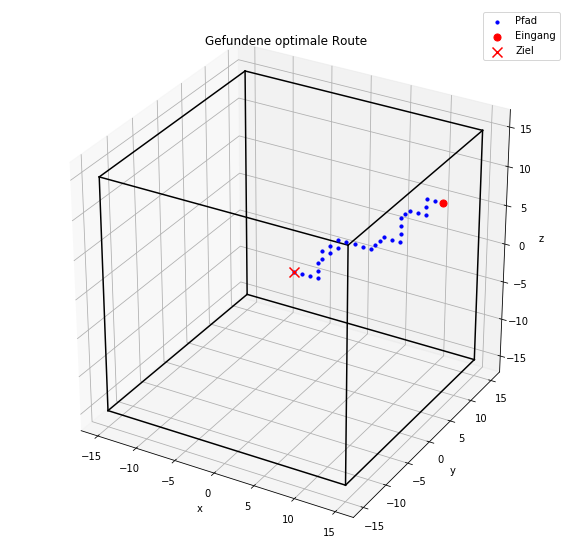

In [14]:
%matplotlib inline

from itertools import product, combinations

fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')

# Pfad in array umwandeln
np_final_path = np.array(final_path)

# Finalen Pfad plotten
for j in range (len(np_final_path)):
    ax.scatter([np_final_path[j][0]], [np_final_path[j][1]], [np_final_path[j][2]], color="b", s=10, label="Pfad", zorder=-1)

# Startpunkt plotten
ax.scatter([15],[6],[10], color="r", s=50, label="Eingang")

# Ziel plotten
ax.scatter([0],[0],[0], color="r", s=100, label="Ziel", marker="x")

# Würfel einzeichnen
r = [-15, 15]
for s, e in combinations(np.array(list(product(r, r, r))), 2):
    if np.sum(np.abs(s-e)) == r[1]-r[0]:
        ax.plot3D(*zip(s, e), color="black")

# Legende
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys())

# Titel und Achsenbeschriftung
#plt.title("Optimale Route zur Erorberung des BORG KUBUS", fontsize=20)
ax.set_title("Gefundene optimale Route")

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

plt.show()

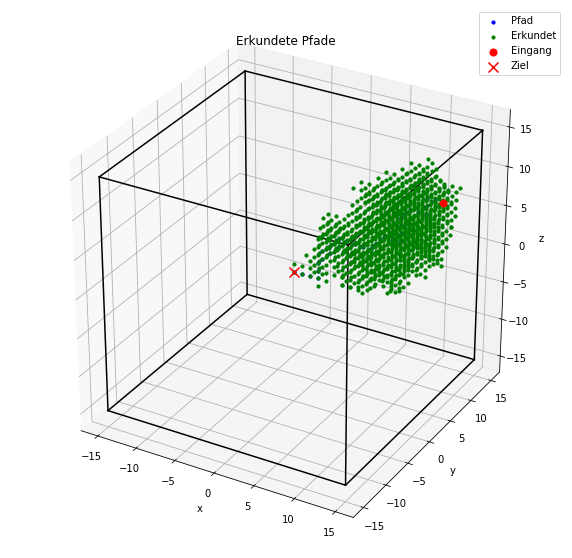

In [15]:
%matplotlib inline

from itertools import product, combinations

fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')

# Pfad in array umwandeln
np_final_path = np.array(final_path)

# Finalen Pfad plotten
for j in range (len(np_final_path)):
    ax.scatter([np_final_path[j][0]], [np_final_path[j][1]], [np_final_path[j][2]], color="b", s=10, label="Pfad", zorder=-1)

# Erkundete Pfade plotten
for h in range(len(final_closed)):
    final_cl = np.array(final_closed[h].position)
    if final_cl[0] > 15 or final_cl[1] > 15 or final_cl[2] > 15 or final_cl[0] < -15 or final_cl[1] < -15 or final_cl[2] < -15:
        continue
    else:
        ax.scatter([final_cl[0]], [final_cl[1]], [final_cl[2]], color="green", s=10, label="Erkundet", zorder=-1)

# Startpunkt plotten
ax.scatter([15],[6],[10], color="r", s=50, label="Eingang")

# Ziel plotten
ax.scatter([0],[0],[0], color="r", s=100, label="Ziel", marker="x")

# Würfel einzeichnen
r = [-15, 15]
for s, e in combinations(np.array(list(product(r, r, r))), 2):
    if np.sum(np.abs(s-e)) == r[1]-r[0]:
        ax.plot3D(*zip(s, e), color="black")

# Legende
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys())

# Titel und Achsenbeschriftung
#plt.title("Optimale Route zur Erorberung des BORG KUBUS", fontsize=20)
ax.set_title("Erkundete Pfade")

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

plt.show()

## Video

Der folgende Code wurde verwendet, um das Video aus der Abgabe zu generieren. Er wurde aufgrund seiner langen Laufzeit hier auskommentiert.

In [16]:
# %matplotlib notebook

# from matplotlib import animation
# from IPython.display import HTML

# fig = plt.figure(figsize=(15,15))
# ax = fig.add_subplot(111, projection='3d')

# # draw cube
# r = [-15, 15]
# for s, e in combinations(np.array(list(product(r, r, r))), 2):
#     if np.sum(np.abs(s-e)) == r[1]-r[0]:
#         ax.plot3D(*zip(s, e), color="black")

# # draw path
# np_final_path = np.array(final_path)

# # Finalen Pfad plotten
# for j in range (len(np_final_path)):
#     ax.scatter([np_final_path[j][0]], [np_final_path[j][1]], [np_final_path[j][2]], color="b", s=10, label="Pfad")
# ax.scatter([15],[6],[10], color="r", s=50, label="Eingang")
# ax.scatter([0],[0],[0], color="r", s=100, label="Ziel", marker="x")
# handles, labels = plt.gca().get_legend_handles_labels()
# by_label = dict(zip(labels, handles))
# plt.legend(by_label.values(), by_label.keys())
# plt.title("Optimale Route zur Erorberung des BORG KUBUS", fontsize=20)

# ax.set_xlabel('x')
# ax.set_ylabel('y')
# ax.set_zlabel('z')

# def animate(frame):
#   ax.view_init(20, frame/4 + 75)
#   plt.pause(.001)
#   return fig

# anim = animation.FuncAnimation(fig, animate, frames=180*4, interval=50)
# HTML(anim.to_html5_video())